In [1]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
data = np.load("tabletop_data.npz",allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


renderer = j.Renderer(intrinsics)

model_dir = os.path.join(j.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path)

table_params = data["table_params"]
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]
renderer.add_mesh(table_mesh)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [7]:
R_SWEEP = jnp.array([30.0, 5.0, 1.0, 0.1, 0.01]).reshape(-1,1)
OUTLIER_PROBS = jnp.linspace(0.01, 0.3, 4)
OUTLIER_VOLUME = 1000.0**3
SCALING_FACTOR = 3

contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -200.0, -200.0, -jnp.pi,
        200.0, 200.0, jnp.pi,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -20.0, -20.0, -jnp.pi/5,
        20.0, 20.0, jnp.pi/5,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -2.0, -2.0, -jnp.pi/5/5,
        2.0, 2.0, jnp.pi/5/5,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -0.0, -0.0, -jnp.pi,
        0.0, 0.0, jnp.pi,
        1,1,7*7
    ),

]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


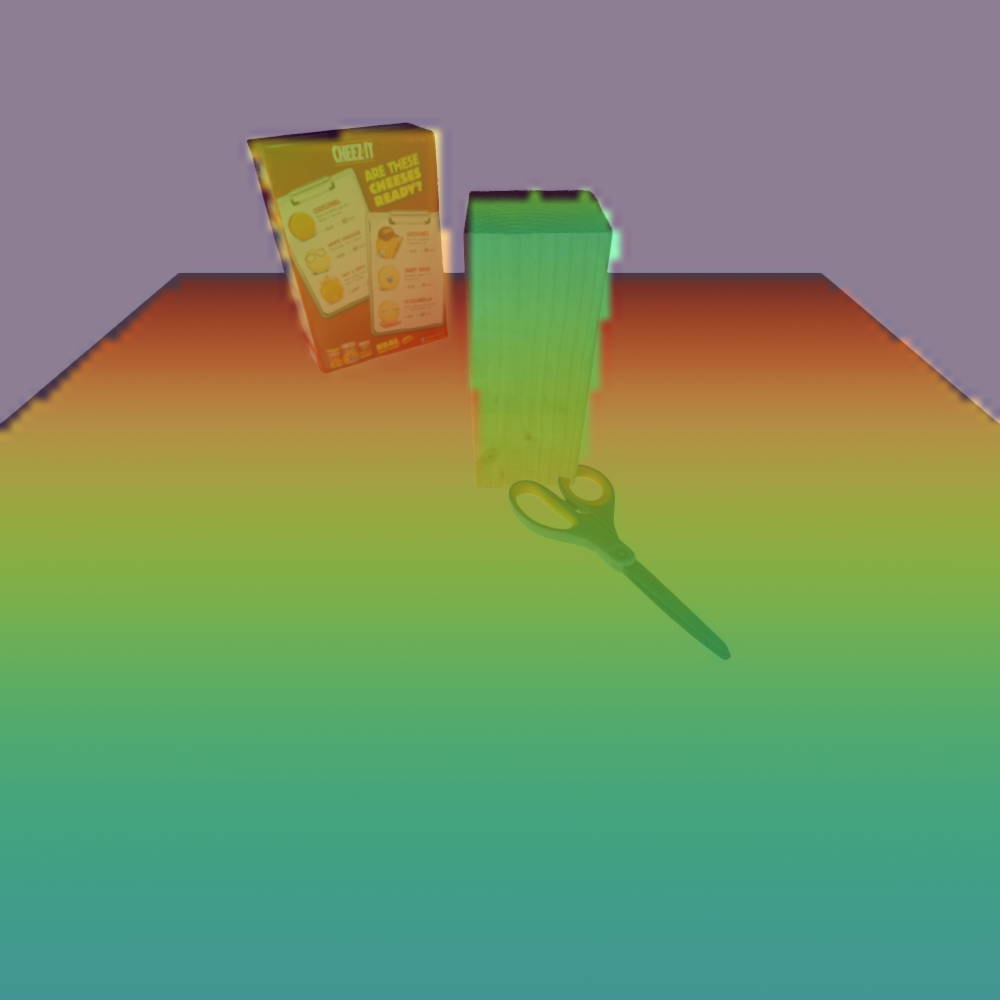

In [25]:
iter = 23
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")
    
data = np.load(DATASET_FILE,allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


observed_point_cloud_image = renderer.render_multiobject(
    jnp.concatenate([poses, table_pose[None,...]]),
    jnp.concatenate([indices, jnp.array([21])])
)
j.get_rgb_image(rgb)
j.overlay_image(
    j.get_rgb_image(rgb),
    j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), 10)
)


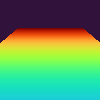

In [21]:
R = jnp.ones((R_SWEEP.shape[0],2)) * 0.0001
object_poses, object_ids = table_pose[None, None,...], [21]
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)


j.get_depth_image(reconstruction[:,:,2])

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 4.53844e-40 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]
[17  4 16  2 11  1  0  8 13  3 15  9  6 18 20  7  5 12 14 19 10]
Best
[1.e-04 1.e-04 1.e-01 3.e+01 1.e+00 3.e+01] 0.01 17


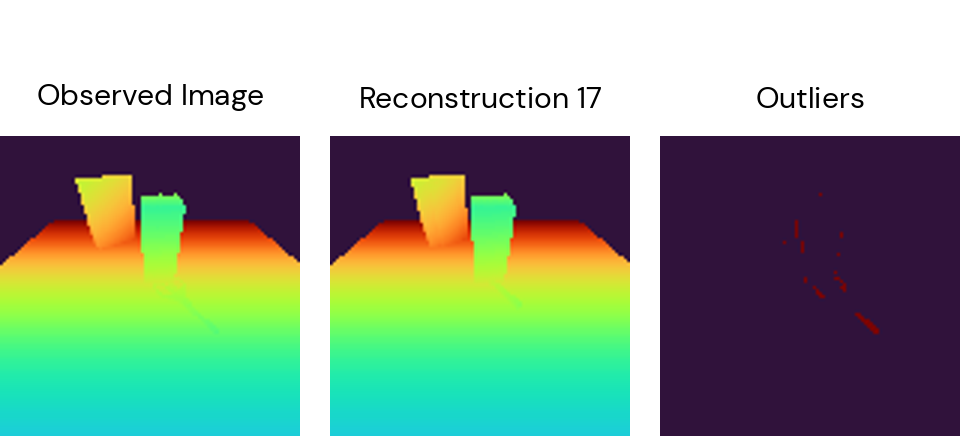

In [26]:
all_hypotheses = []
for obj_id in range(21):
#     print("Object Id : ", obj_id)

    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param
        
        potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
            contact_plane
        )
        POTENTIAL_R = jnp.hstack([R,R_SWEEP])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(observed_point_cloud_image, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1], POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME)
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]

    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print(j.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = POTENTIAL_R.at[:,:].set(best_r)
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]


outliers = (
    (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)

# height_factor = outlier_prob_viz.height / observed_image_viz.height

viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:d} : {:0.3f}".format(idx, i[0].item()) for (idx,i) in enumerate(all_hypotheses)]
)
viz2 = j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction {:d}".format(jnp.argmax(scores)),
        "Outliers",
    ],
    middle_width=30
)

viz2

In [66]:
R[0]

Array([1.e-04, 1.e-04, 1.e+00, 1.e-01, 3.e+01], dtype=float32)

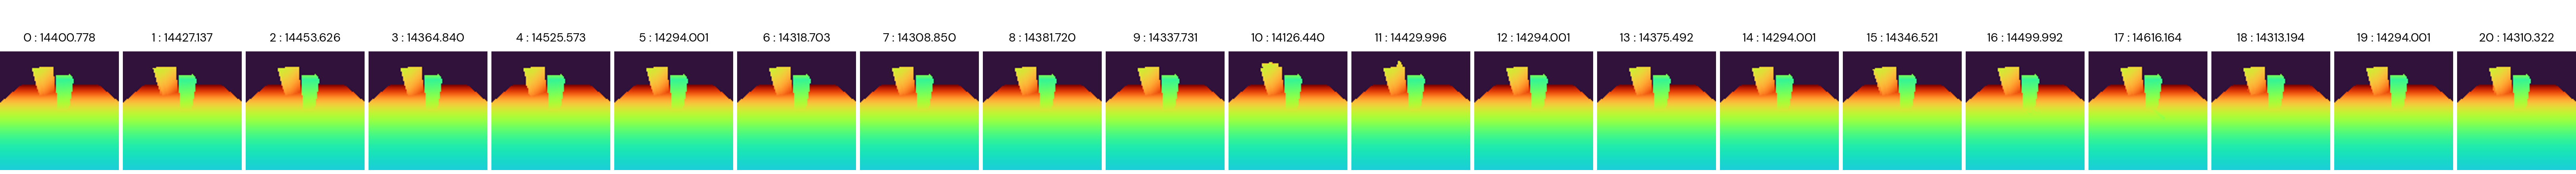

In [27]:
viz1

In [28]:
print(object_ids[1:])
print(indices)

[15, 1, 15, 17]
[16 15  1]


In [19]:
j.ycb_loader.MODEL_NAMES[15]

'036_wood_block'

In [25]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [42]:
GT_R = 30.0
original_observed_image = observed_point_cloud_image[:,:,:3]
point_cloud = original_observed_image.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * GT_R
    )
)(
    jax.random.split(jax.random.PRNGKey(2), point_cloud.shape[0])
)
point_cloud_noisy = noise + point_cloud
# j.meshcat.show_cloud("1", point_cloud_noisy / 200.0)


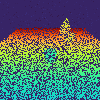

In [43]:

# point_cloud_noisy = point_cloud
observed_image = point_cloud_noisy.reshape(original_observed_image.shape)
# observed_depth = j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2]
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
# observed_image = j.t3d.unproject_depth_jit(observed_depth, intrinsics)
observed_image_viz = j.get_depth_image(j.render_point_cloud(point_cloud_noisy, intrinsics)[:,:,2])
observed_image_viz

In [ ]:
z